# Flood Impact Mapping with UP42

In the following tutorial we will map the impact of the flooding in urban area using UP42 python SDK and OpenStreetMap data.

This notebook is intended to show how your existing GIS analysis and workflows can seemlessly be integrated with UP42 Python SDK in a few lines of code.

The notebook is divided in following sections:
1. Download Sentinel-2 AOI clipped GeoTiff with UP42 data-block
2. Calculate Modified Normalized Water Index (MNDWI)
3. Convert MNDWI raster mask to vector mask
4. Extract building footprints polygons from OSM (with awesome osmnx) library
5. Plot the impacted buildings with Folium

> **Additional Package Requirement(s)** <br>
> `$ pip install osmnx` <br>

In [ ]:
# !pip install -U osmnx

In [2]:
# imports
import os
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
from rasterio import features
from rasterio.plot import reshape_as_raster, show
from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box
from shapely.geometry import shape as shapely_shp
from shapely.ops import cascaded_union, transform

import folium
import osmnx as ox
import up42

In [3]:
# allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Set-up data directory to work with. This is optional though. The SDK creates a directory in the project folder for you!

In [4]:
data_dir = './tmp'

## Download data from UP42 platform

In [5]:
# authenticate 
up42.authenticate(cfg_file="flood_config.json")

2020-05-13 16:08:25,244 - up42.auth - INFO - Got credentials from config file.
2020-05-13 16:08:25,706 - up42.auth - INFO - Authentication with UP42 successful!


In [6]:
project = up42.initialize_project()
    
# init workflow
workflow = project.create_workflow(name="flooding", use_existing=True)

2020-05-13 16:08:25,711 - up42 - INFO - Working on Project with project_id 28f674f9-0886-4fab-8774-c9ee4d54eea1
2020-05-13 16:08:26,150 - up42.project - INFO - Getting existing workflows in project ...
2020-05-13 16:08:26,607 - up42.project - INFO - Got 1 workflows for project 28f674f9-0886-4fab-8774-c9ee4d54eea1.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
2020-05-13 16:08:27,081 - up42.project - INFO - Using existing workflow: flooding, 89d31c7e-8f46-4c4a-9d26-ef90496250a4.


In [7]:
def get_data(wf_name, inp_tasks, aoi_gjson, geom_op, start, end, data_dir=data_dir, limit=1):
    # init project
    project = up42.initialize_project()
    
    # init workflow
    workflow = project.create_workflow(name=wf_name, use_existing=True)
    input_tasks = inp_tasks
    workflow.add_workflow_tasks(input_tasks=input_tasks)
    aoi = workflow.read_vector_file(aoi_gjson, as_dataframe=True)
    input_parameters = workflow.construct_parameters(geometry=aoi, 
                                                 geometry_operation=geom_op, 
                                                 start_date=start,
                                                 end_date=end,
                                                 limit=limit)
    
    # Run the actual job
    job = workflow.run_job(input_parameters=input_parameters, track_status=True)
    job.download_results(data_dir)
    job.download_quicklooks(data_dir)

    return job

Following will fetch the data from UP42 platform corresponding the AOI and parameters we passed into the function.

The area of interest is based on 2019 flooding events in Mid-West, USA in 2019. [Bellevue](https://goo.gl/maps/8UTHGfrLp8KuKk617)

In [8]:
job = get_data(wf_name="flooding",
             inp_tasks=['sentinelhub-s2-aoiclipped'],
             aoi_gjson="./data/aoi_bellevue_US.geojson",
             geom_op="contains",
             start="2019-03-21",
             end="2019-03-21"
)

2020-05-13 16:08:27,095 - up42 - INFO - Working on Project with project_id 28f674f9-0886-4fab-8774-c9ee4d54eea1
2020-05-13 16:08:27,543 - up42.project - INFO - Getting existing workflows in project ...
2020-05-13 16:08:27,994 - up42.project - INFO - Got 1 workflows for project 28f674f9-0886-4fab-8774-c9ee4d54eea1.
100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
2020-05-13 16:08:28,475 - up42.project - INFO - Using existing workflow: flooding, 89d31c7e-8f46-4c4a-9d26-ef90496250a4.
2020-05-13 16:08:29,911 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'sentinelhub-s2-aoiclipped:1', 'parentName': None, 'blockId': '018dfb34-fc19-4334-8125-14fd7535f979'}]
2020-05-13 16:08:30,474 - up42.workflow - INFO - Selected input_parameters: {'sentinelhub-s2-aoiclipped:1': {'time': '2019-03-21T00:00:00Z/2019-03-21T00:00:00Z', 'limit': 1, 'zoom_level': 14, 'contains': {'type': 'Polygon', 'coordinates': (((-95.929012, 41.114021), (-95.928326, 41.124884), (-95.922832, 41.132642), (-95.906868, 4

You should see a new folder named `tmp` being created in the current working directory with `.tif` and meatadata file `data.json`. Additionally, we downloaded quicklooks `.jpg` with `job.download_quicklooks()`. This will come handy later while visualising on a folium map.
> **NOTE:** The SDK automatically creates the download directory if not already exists.

In [9]:
# store results and quicklook paths to separate variables
raster_path = [i for i in job.results if i.endswith('.tif')][0]
metadata_path = [i for i in job.results if i.endswith('.json')][0]

In [10]:
# similarly store path for quicklook
ql_path = job.quicklooks[0]

Now, that we have downloaded the necessary data let's move on to the next steps!

In [11]:
raster_path, metadata_path

('tmp/496a6bc2-2af2-4e5b-b11d-d14c336e6855.tif', 'tmp/data.json')

## Calculate MNDWI

The Modified Normalized Difference Water Index (MNDWI) uses green and SWIR bands for the enhancement of open water features. It also diminishes built-up area features that are often correlated with open water in other indices.

MNDWI = (Green - SWIR) / (Green + SWIR)

- Green = pixel values from the green band
- SWIR = pixel values from the short-wave infrared band

> **Reference**: http://space4water.org/taxonomy/term/1246

In [12]:
# read data with rasterio
dataset = rio.open(raster_path)

In [13]:
# read bands
# B03 -> green
# B11 -> SWIR
green = dataset.read(3)
swir = dataset.read(11)

In [14]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [15]:
def calc_mndwi(green_band, swir_band):
    mndwi = (green_band - swir_band) / (green_band + swir_band)
    return mndwi.astype(np.float32)

In [16]:
# normalize
green_n = normalize(green)
swir_n = normalize(swir)

In [17]:
mndwi = calc_mndwi(green_band=green_n, swir_band=swir_n)

Let's quickly plot and see how it looks like

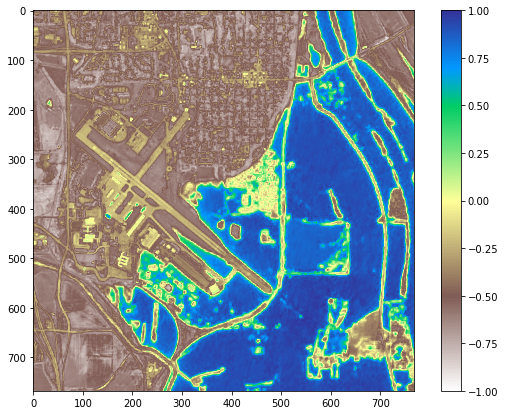

In [18]:
plt.figure(figsize=(10, 7))
plt.imshow(mndwi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar();

As we can see the water area is depicted in blue where as land area is brown(-ish) color

In [19]:
# close the dataset
dataset.close()

## Create Vector Mask

Now that we have computed MNDWI, next step is to isolate boundaries of flooded area from whole image.

This means,
- Apply a deterministic decision boundary / threshold to NDWI values
- Translate the threshold values into boolean value mask (1/0)
- Convert raster into vector boundary (multipolygon)

According the [NDWI-wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_water_index):<br>

> For the second variant of the NDWI, another threshold can also be found in that avoids creating false alarms in urban areas:
> - < 0.3 - Non-water
> - &gt;= 0.3 - Water

Meaning all the values that are `>= 0.3` will be mapped to value `true` and `< 0.3` to `false` respectively.

In [20]:
# create numpy mask
mndwi_msk = (mndwi >= 0.3)

### Pixel to shapely geom

In [21]:
mypoly=[]
for vec, val in features.shapes(source=mndwi_msk.astype(np.float32), transform=dataset.transform):
    mypoly.append({'geom': shapely_shp(vec), 'value': val})

Now, let's convert this to `GeoDataFrame` as it will be easy to do vector based operations as well as to create viz.

In [22]:
# to gdf
submerged = gpd.GeoDataFrame(mypoly, crs=dataset.crs, geometry='geom')

In [23]:
# value counts
submerged['value'].value_counts()

1.0    203
0.0    138
Name: value, dtype: int64

We see that `submerged` have two unique values (0.0, 1.0). However, `1.0` corresponds to `water` so it makes sense to filter out land-area from gdf.

In [24]:
# filter by water area
submerged = submerged[submerged['value'] > 0]

In [25]:
# shape should be 203 based on value count cell above
submerged.shape[0]

203

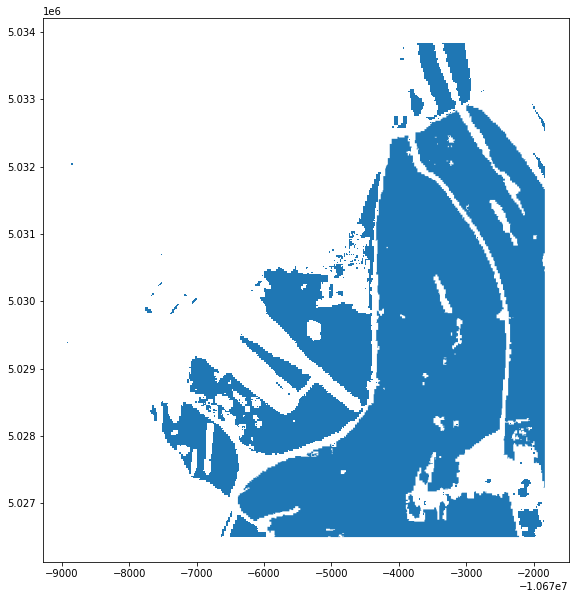

In [26]:
# quick plot
submerged.plot(figsize=(15, 10));

Now that we have vectorized boundaries of flooded area which we will use to intersect with building footprint polygons from OSM. It is better to collapse all individual polygons into a single Multipolygon geometry. <br>
Also, note the x and y axis values!! (**HINT:** crs)

In [27]:
boundary = cascaded_union(list(submerged['geom']))

## Retrieve Building Footprints from OSM

For this we will use, OSMNx library by Geoff Boeing. This library comes with readily available function to extract building footprints given bounding box.

**Caveat(s):**
- OSMNx expects input in WGS84 (`EPSG:4326`) whereas out data is in psuedo-mercator projection (`EPSG:3857`)
- We need some coordinate system transformation here, for both, OSM data retrieval as well as plotting 

In [28]:
# transform crs
crs_project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'), # source coordinate system
    pyproj.Proj(init='epsg:4326') # destination coordinate system
)

In [29]:
# read bounds from dataset and transform to wgs84 because osmnx expects epsg:4326 :/
osm_poly = transform(crs_project, box(*dataset.bounds))

Now, we have everything we need to extract data from OSM

In [30]:
gdf = ox.footprints_from_polygon(polygon=osm_poly)

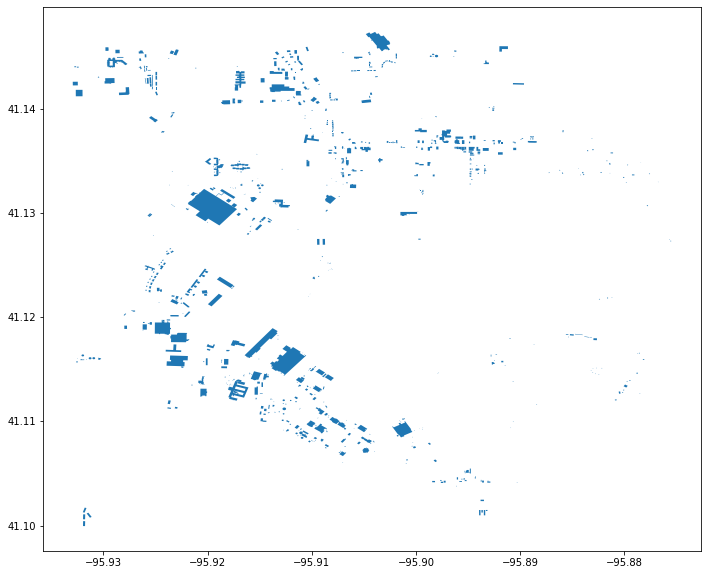

In [31]:
gdf.plot(figsize=(15, 10))

Notice that the coordinates, here, are in (lat, lon). Now, that data is extracted, we can transform it to the crs of the dataset.

Doing this right now prevents any inconsistencies (with plotting, intersecting etc.) at later point as well as ensures sanity!!

In [32]:
gdf_proj = ox.project_gdf(gdf, to_crs=dataset.crs)

In [33]:
gdf_proj.head(1)

,nodes,building,layer,geometry,ref,ref:source,source,name,access,amenity,...,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,barrier,smoking,lit,members,type
32811010,"[369730571, 2007636330, 2007636643, 2007635719...",hangar,1,"POLYGON ((-10675793.142 5028506.241, -10675786...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract Flood Impacted buildings

Until this point, we set the stage for actual task. Basically, the building footprints that intersects the Multipolygon (one we created from MNDWI) are effected building and those that are not are not-effected buildings!

In [34]:
effected = gdf_proj[gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
effected.to_crs(crs='EPSG:4326', inplace=True)

/Users/prayag.thakkar/Envs/up42-py/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [35]:
not_effected = gdf_proj[~gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
not_effected.to_crs(crs='EPSG:4326', inplace=True)

/Users/prayag.thakkar/Envs/up42-py/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [36]:
# quick sanity check
gdf_proj.shape[0] == (effected.shape[0] + not_effected.shape[0])

True

It's time for plotting. We will use Folium library for displaying our results. Of course, it requires a bit of massaging before we get to the plotting

### Plotting

In [37]:
# bbox centroid serves as the center point for the folium map
bbox_centroid = list((osm_poly.centroid).coords[:][0])
bbox_centroid = [bbox_centroid[-1], bbox_centroid[0]]
bbox_centroid

[41.12074089370247, -95.899658203125]

In [38]:
# extracts bounds for image overlay
lon_min, lat_min, lon_max, lat_max = osm_poly.bounds

In [39]:
style1 = {'fillColor': '#228B22', 'color': 'red'}
style2 = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF'}

In [40]:
# init folium map
m = folium.Map(bbox_centroid, zoom_start=15)

# add effected buildings
folium.GeoJson(effected.to_json(), style_function=lambda x:style1).add_to(m);

# add not_effected buildings
folium.GeoJson(not_effected.to_json(), style_function=lambda x:style2).add_to(m);

# add raster png quicklook
folium.raster_layers.ImageOverlay(image=ql_path, bounds=[[lat_min, lon_min], [lat_max, lon_max]], opacity=0.8).add_to(m);

In [41]:
folium.LayerControl().add_to(m)
m

As we can see the buildings impacted by flooding in red and those that are not impacted are in blue.

It should be noted that success of the analysis depends on the availability of the data in OSM!!